# Rohlik Sales Forecasting Challenge

## 1. Importing libraries

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.set_context("notebook")

## 2. Data Loading

In [170]:
sales_train = pd.read_csv("data/sales_train.csv")
sales_test = pd.read_csv("data/sales_test.csv")
inventory = pd.read_csv("data/inventory.csv")
calendar = pd.read_csv("data/calendar.csv")
test_weights = pd.read_csv("data/test_weights.csv")

## 3. Quick Exploratory Data Analysis (EDA)

Train Data Shape: (4007419, 14)
Test Data Shape:  (47021, 12)
Inventory Shape:  (5432, 8)
Calendar Shape:   (23016, 7)


,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,0.0,0.15312,0.0,0.0
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,0.0,0.15312,0.0,0.0
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,0.0,0.15649,0.0,0.0


,unique_id,date,warehouse,total_orders,sell_price_main,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount
0,1226,2024-06-03,Brno_1,8679.0,13.13,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,1226,2024-06-11,Brno_1,8795.0,13.13,0.15873,0.0,0.0,0.0,0.0,0.0,0.0
2,1226,2024-06-13,Brno_1,10009.0,13.13,0.15873,0.0,0.0,0.0,0.0,0.0,0.0
3,1226,2024-06-15,Brno_1,8482.0,13.13,0.15873,0.0,0.0,0.0,0.0,0.0,0.0
4,1226,2024-06-09,Brno_1,8195.0,13.13,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


,unique_id,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,warehouse
0,5255,2583,Pastry_196,Bakery,Bakery_L2_14,Bakery_L3_26,Bakery_L4_1,Prague_3
1,4948,2426,Herb_19,Fruit and vegetable,Fruit and vegetable_L2_30,Fruit and vegetable_L3_86,Fruit and vegetable_L4_1,Prague_3
2,2146,1079,Beet_2,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_65,Fruit and vegetable_L4_34,Prague_1
3,501,260,Chicken_13,Meat and fish,Meat and fish_L2_13,Meat and fish_L3_27,Meat and fish_L4_5,Prague_1
4,4461,2197,Chicory_1,Fruit and vegetable,Fruit and vegetable_L2_17,Fruit and vegetable_L3_33,Fruit and vegetable_L4_1,Frankfurt_1


,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,warehouse
0,2022-03-16,NaN,0,0,0,0,Frankfurt_1
1,2020-03-22,NaN,0,0,0,0,Frankfurt_1
2,2018-02-07,NaN,0,0,0,0,Frankfurt_1
3,2018-08-10,NaN,0,0,0,0,Frankfurt_1
4,2017-10-26,NaN,0,0,0,0,Prague_2



Missing values in training data:
unique_id           0
date                0
warehouse           0
total_orders       52
sales              52
sell_price_main     0
availability        0
type_0_discount     0
type_1_discount     0
type_2_discount     0
type_3_discount     0
type_4_discount     0
type_5_discount     0
type_6_discount     0
dtype: int64


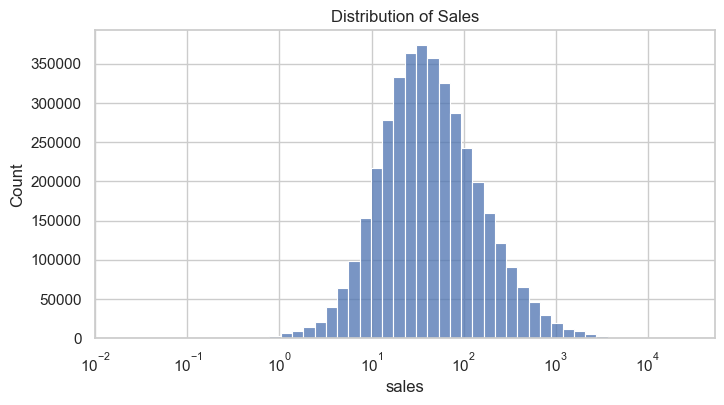

In [171]:
print("Train Data Shape:", sales_train.shape)
print("Test Data Shape: ", sales_test.shape)
print("Inventory Shape: ", inventory.shape)
print("Calendar Shape:  ", calendar.shape)

# Display a sample of each
display(sales_train.head())
display(sales_test.head())
display(inventory.head())
display(calendar.head())

# Check for missing values
print("\nMissing values in training data:")
print(sales_train.isnull().sum())

# A quick look at distribution of the target
plt.figure(figsize=(8, 4))
sns.histplot(sales_train["sales"], bins=50, log_scale=True)
plt.title("Distribution of Sales")
plt.show()

### 3.1 Handling Missing Values

In [172]:
# Convert empty holiday_name strings to NaN
calendar["holiday_name"] = calendar["holiday_name"].replace("", np.nan)

# Sort by warehouse and date so forward-fill works in time order
calendar["date"] = pd.to_datetime(calendar["date"])  # ensure date is datetime
calendar.sort_values(["warehouse", "date"], inplace=True)

# Forward-fill holiday_name ONLY for rows where holiday == 0
#    We'll do this by creating a mask for non-holiday rows, then ffill within groups.
def forward_fill_non_holiday(df):
    # For each warehouse group:
    #   forward-fill 'holiday_name' but only where 'holiday' == 0
    mask_non_holiday = (df["holiday"] == 0)
    # Temporarily store holiday_name for non-holiday rows in a separate column
    df.loc[mask_non_holiday, "holiday_name_non_holiday"] = df.loc[mask_non_holiday, "holiday_name"]
    # Forward-fill only that separate column
    df["holiday_name_non_holiday"] = df["holiday_name_non_holiday"].ffill()
    # Now put the forward-filled values back into 'holiday_name' for non-holiday rows
    df.loc[mask_non_holiday, "holiday_name"] = df.loc[mask_non_holiday, "holiday_name_non_holiday"]
    # Clean up the helper column
    df.drop(columns=["holiday_name_non_holiday"], inplace=True)
    return df

calendar = (
    calendar
    .groupby("warehouse", group_keys=False)
    .apply(forward_fill_non_holiday)
    .reset_index(drop=True)
)

# Fill any remaining NaNs in holiday_name with a default like "No"
calendar["holiday_name"].fillna("No", inplace=True)


/var/folders/8l/df7brwpx0vj8qwl22c82bj5w0000gn/T/ipykernel_3525/1993512781.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(forward_fill_non_holiday)
/var/folders/8l/df7brwpx0vj8qwl22c82bj5w0000gn/T/ipykernel_3525/1993512781.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perfor

### 3.2 Outlier Detection and Handling

In [173]:
def detect_outliers_iqr_grouped(
    df: pd.DataFrame,
    group_cols: list,
    target_col: str,
    iqr_multiplier: float = 1.5,
    add_column: str = "outlier"
) -> pd.DataFrame:
    """
    Detect outliers for each group based on IQR and create a boolean column indicating outliers.
    
    Args:
        df (pd.DataFrame): The DataFrame to operate on.
        group_cols (list): The columns to group by (e.g. ["unique_id"], or ["unique_id", "warehouse"]).
        target_col (str): The column to detect outliers in.
        iqr_multiplier (float): The multiplier for the IQR range (default=1.5).
        add_column (str): The name of the outlier indicator column added to the DataFrame.

    Returns:
        pd.DataFrame: The DataFrame with an additional boolean column `add_column` marking outliers.
    """
    
    def _detect_outliers_in_group(group):
        Q1 = group[target_col].quantile(0.25)
        Q3 = group[target_col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR

        # Create a boolean mask for outliers
        group[add_column] = (group[target_col] < lower_bound) | (group[target_col] > upper_bound)

        # Clip the target column to the bounds
        group[target_col] = np.clip(group[target_col], lower_bound, upper_bound)

        return group

    # Apply the function group-wise
    df = df.groupby(group_cols, group_keys=False).apply(_detect_outliers_in_group)
    return df

Let's apply the Outlier Detection method to the sales data

In [174]:
# Apply IQR method to detect outliers for the train and test data
sales_train = detect_outliers_iqr_grouped(
    df=sales_train,
    group_cols=["unique_id", "warehouse"],
    target_col="sales",
    iqr_multiplier=4
)

# Display the outliers
display(sales_train[sales_train["outlier"]])


/var/folders/8l/df7brwpx0vj8qwl22c82bj5w0000gn/T/ipykernel_3525/1971542247.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(group_cols, group_keys=False).apply(_detect_outliers_in_group)


,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount,outlier
1608,4829,2023-12-20,Prague_2,8961.0,50.9050,191.09,1.00,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,True
1941,4829,2023-01-02,Prague_2,4648.0,50.9050,191.09,0.53,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,True
2617,1755,2022-12-20,Brno_1,13867.0,502.4600,28.39,1.00,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,True
2646,1755,2023-11-09,Brno_1,9163.0,502.4600,32.45,1.00,0.20921,0.0,0.0,0.0,0.0,0.0,0.0,True
2831,1755,2023-02-17,Brno_1,9940.0,502.4600,31.10,1.00,0.25105,0.0,0.0,0.0,0.0,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4006764,925,2024-05-10,Brno_1,10415.0,112.6525,76.31,0.88,0.31534,0.0,0.0,0.0,0.0,0.0,0.0,True
4006769,925,2024-05-09,Brno_1,9502.0,112.6525,76.31,0.70,0.31534,0.0,0.0,0.0,0.0,0.0,0.0,True
4006782,925,2024-05-07,Brno_1,12260.0,112.6525,76.31,0.98,0.31534,0.0,0.0,0.0,0.0,0.0,0.0,True
4006921,2263,2022-09-24,Munich_1,2726.0,393.3900,0.74,0.80,0.20000,0.0,0.0,0.0,0.0,0.0,0.0,True


## 4. Basic Data Preparation & Feature Engineering
### 4.1 Merge 'inventory' info to get product/category features

In [175]:
# We merge on ["unique_id", "warehouse"] because
# 'inventory.csv' also has "warehouse" column that might differ
train_merged = sales_train.merge(
    inventory.drop_duplicates(subset=["unique_id", "warehouse"]),
    on=["unique_id", "warehouse"],
    how="left",
)

test_merged = sales_test.merge(
    inventory.drop_duplicates(subset=["unique_id", "warehouse"]),
    on=["unique_id", "warehouse"],
    how="left",
)

### 4.2 Merge calendar data (for holidays, closures, etc.)

In [176]:
# Convert date to datetime
train_merged["date"] = pd.to_datetime(train_merged["date"])
test_merged["date"] = pd.to_datetime(test_merged["date"])

# Merge calendar data
train_merged = train_merged.merge(
    calendar, on=["warehouse", "date"], how="left"
)

test_merged = test_merged.merge(
    calendar, on=["warehouse", "date"], how="left"
)

# Sort training data by date (useful for time-series modeling)
train_merged.sort_values(["unique_id", "date"], inplace=True)

### 4.3 Basic Feature Ideas

In [177]:
# Let's create a few naive features, such as:
#  - day of week
#  - month
#  - if it's a holiday or not

train_merged["day_of_week"] = train_merged["date"].dt.dayofweek
train_merged["month"] = train_merged["date"].dt.month

test_merged["day_of_week"] = test_merged["date"].dt.dayofweek
test_merged["month"] = test_merged["date"].dt.month


## 5. Simple Baseline Model

Let's create a naive model that predicts the average of past 7 days of "sales" for each unique_id (or fewer if 7 days are not available).

### 5.1 Create a validation split to measure Weighted MAE

We'll pick the last X days from training as validation. Let's take the last 14 days in training for each unique_id. This is just an illustration; choose a robust method to create your validation.

In [178]:
# Sort train_merged by date
train_merged.sort_values(["unique_id", "date"], inplace=True)

# For quick demonstration, let's pick a single "validation start date"
val_start_date = train_merged["date"].max() - pd.Timedelta(days=14)

# Split
train_data = train_merged[train_merged["date"] < val_start_date].copy()
val_data   = train_merged[train_merged["date"] >= val_start_date].copy()

print("Training set shape:", train_data.shape)
print("Validation set shape:", val_data.shape)

Training set shape: (3956941, 28)
Validation set shape: (50478, 28)


### 5.2 Weighted Mean Absolute Error (WMAE) function

In [179]:
def weighted_mae(y_true, y_pred, weights):
    """
    y_true: np.array of true values
    y_pred: np.array of predicted values
    weights: np.array of weights
    """
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

# We'll need 'test_weights' only for final test predictions.
# For validation, let's create a simple weight = 1 for all.
val_data["weight"] = 1.0

### 5.3 Naive Forecasting Approach

In [180]:
# Let's define a function to get the last 7-day average from training data.
def get_last_7day_avg(df):
    """
    For each unique_id & date in df,
    compute the average sales of the previous 7 days from the training data.
    """
    df = df.sort_values(["unique_id", "date"])
    # We'll group by unique_id and use a rolling window on daily sales
    df["sales_lag7_avg"] = (
        df.groupby("unique_id")["sales"]
          .transform(lambda x: x.shift(1).rolling(7, min_periods=1).mean())
    )
    return df

train_data = get_last_7day_avg(train_data)

### 5.4 Make Predictions on Validation

We also need the same rolling feature for "val_data", but it has to come from the training portion (no leakage). A simple approach is to combine them, compute rolling, then separate again.

In [181]:
combined_df = pd.concat([train_data, val_data], ignore_index=True)
combined_df.sort_values(["unique_id", "date"], inplace=True)

combined_df = get_last_7day_avg(combined_df)

# Now re-split
train_data = combined_df[combined_df["date"] < val_start_date].copy()
val_data   = combined_df[combined_df["date"] >= val_start_date].copy()

# Our forecast for val_data is "sales_lag7_avg"
val_data["sales_hat"] = val_data["sales_lag7_avg"]

### 5.5 Evaluate on Validation

In [182]:
val_wmae = weighted_mae(
    y_true=val_data["sales"].values,
    y_pred=val_data["sales_hat"].fillna(0).values,
    weights=val_data["weight"].values
)
print("Validation WMAE:", val_wmae)

Validation WMAE: 27.414478172008927


## 6. Final Model Training on ALL Train Data, then Predict Test

In [183]:
# Recompute rolling 7-day average for the entire train_merged
full_train = train_merged.copy()
full_train.sort_values(["unique_id", "date"], inplace=True)
full_train = get_last_7day_avg(full_train)

# We'll assume that the last known "sales_lag7_avg" for each unique_id
# is our prediction for the next 14 days in the test set. 
# (Extremely naive, but demonstrates the pipeline.)

# We'll get the most recent day for each unique_id from full_train,
# grab the last "sales_lag7_avg", and call that the forecast for each
# row in the test set.

last_sales_avg = (
    full_train
    .groupby("unique_id")["sales_lag7_avg"]
    .last()
    .reset_index()
    .rename(columns={"sales_lag7_avg": "sales_hat"})
)
# Some might be NaN if there's not enough history or no rolling. Fill with 0
last_sales_avg["sales_hat"].fillna(0, inplace=True)

# Merge 'last_sales_avg' into test_merged by unique_id
test_merged = test_merged.merge(last_sales_avg, on="unique_id", how="left")

# Where we have no data at all, fill with 0
test_merged["sales_hat"].fillna(0, inplace=True)

/var/folders/8l/df7brwpx0vj8qwl22c82bj5w0000gn/T/ipykernel_3525/825910610.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  last_sales_avg["sales_hat"].fillna(0, inplace=True)
/var/folders/8l/df7brwpx0vj8qwl22c82bj5w0000gn/T/ipykernel_3525/825910610.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

## 7. Create Submission

In [184]:
# Required submission columns: "id,sales_hat"
# id is in the form "<unique_id>_<date>", e.g. "2317_2024-06-15"

# But note that 'sales_test.csv' might already have "id" or we can create it.
# If not present, create it:
test_merged["id"] = test_merged["unique_id"].astype(str) + "_" + test_merged["date"].dt.strftime("%Y-%m-%d")

submission = test_merged[["id", "sales_hat"]].copy()
submission.sort_values("id", inplace=True)

# Inspect
submission.head(10)

# Finally, save to CSV
submission.to_csv("submission.csv", index=False)

print("Submission file saved: 'submission.csv'")

Submission file saved: 'submission.csv'
